In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 5*x**2 - 5*x + 5

In [3]:
f(3.0)

35.0

In [4]:
xs = np.arange(-7,8, 0.25)
ys = f(xs)

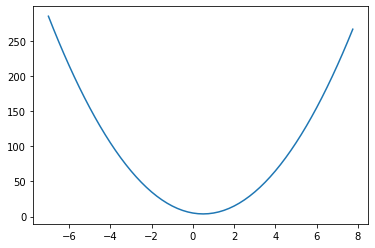

In [5]:
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 0.5
(f(x+h) - f(x))/h

5.018208071305708e-07

In [7]:
## more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [8]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a+=h
d2 = a*b + c
print('d1', d1, 'd2', d2, 'slope', (d2-d1) / h)

d1 4.0 d2 3.999699999999999 slope -3.000000000010772


In [9]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
b+=h
d2 = a*b + c
print('d1', d1, 'd2', d2, 'slope', (d2-d1) / h)

d1 4.0 d2 4.0002 slope 2.0000000000042206


In [135]:

##_children to know the previous value, _op to know which two opertaion between current and prev value
class Value:
    def __init__(self,data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) ## for efficiency
        self._op = _op
        self.label = label
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other),'*')
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self*other
    
    def __radd__(self, other):
        return self+other
    

    def __truediv__(self, other): ## redefine div to a/b = a * b**-1
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ) ,f'**{other}')

        def _backward():
            self.grad +=  (other) * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad +=  out.data * out.grad
        out._backward = _backward
        return out
    

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        ## Topological Sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad =1.0
        for node in reversed(topo): # need to from last to first
            node._backward()


In [85]:
a = Value(2.0); b=Value(4.0)
a- b

Value(data=-2.0)

In [28]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d =e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [32]:
d

Value(data=4.0)

In [29]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [33]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)
    return dot


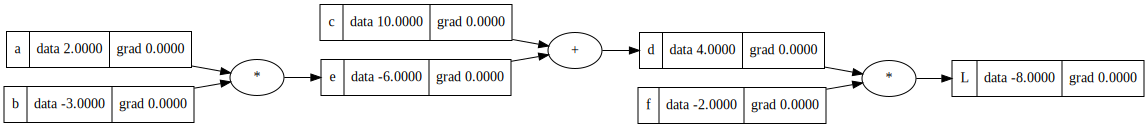

In [34]:
draw_dot(L)

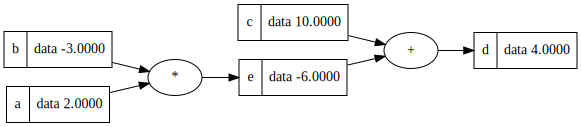

In [22]:
a

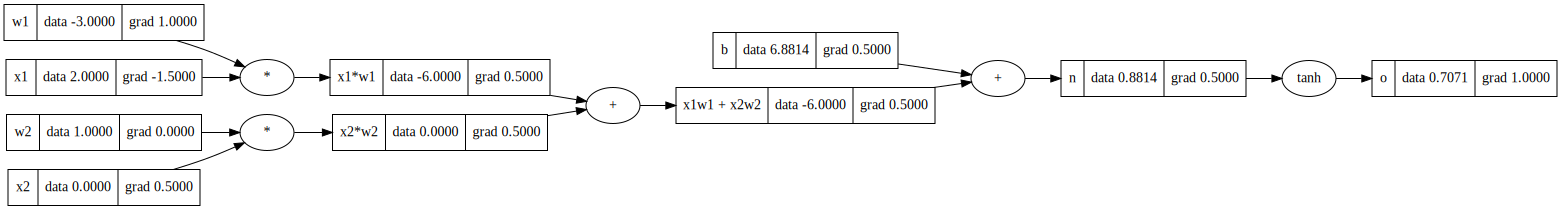

In [88]:
#inp
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#W
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

o.backward()
draw_dot(o)

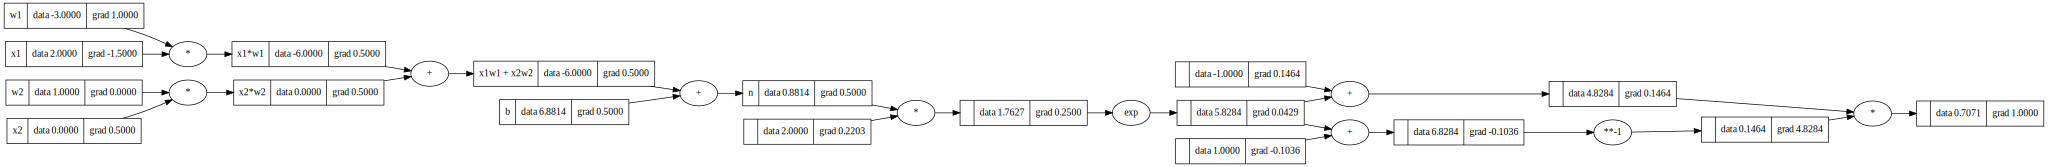

In [89]:
#inp
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#W
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp()
o = (e-1) / (e+1)
o.backward()
draw_dot(o)

In [97]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.881373]).double(); b.requires_grad=True
n = x1*w1  + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--')
print('x2', x2.grad)

0.7071064519863152
--
x2 tensor([0.5000], dtype=torch.float64)


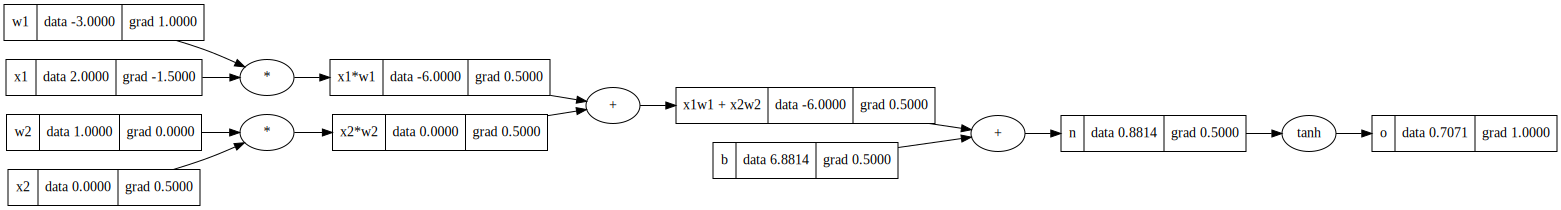

In [87]:

o.backward()
draw_dot(o)

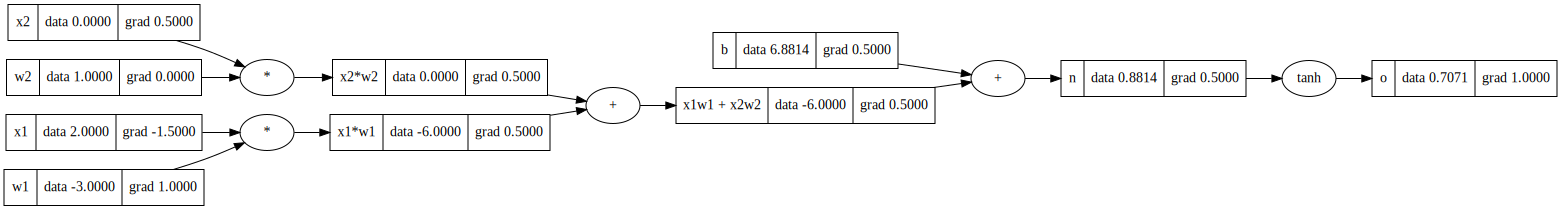

In [57]:
# o.grad=1
draw_dot(o)

In [56]:
x1w1._backward()

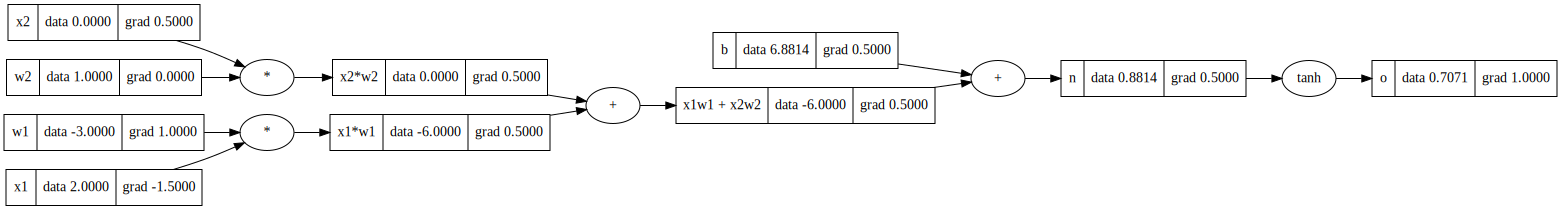

In [62]:
o.grad=1.0

## Topological Sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)


for node in reversed(topo): # need to from last to first
    node._backward()

draw_dot(o)

In [157]:
import random
class Neuron: ## single neuron
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for nueron in self.neurons for p in nueron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.8023002329988647),
 Value(data=0.982120749691044),
 Value(data=-0.9498917405426147)]

In [167]:
len(n.parameters())

41

In [272]:
x = [2.0,3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=0.6460450262729144)

In [273]:
xs = [
    [2.0,3.0, -1.0 ],
    [3.0, -1.0, 0.5],
    [0.5,1.0,1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6460450262729144),
 Value(data=0.5756819320881181),
 Value(data=0.5205501137718419),
 Value(data=0.7534778673335121)]

In [274]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
    ## dont forget to zero grad
    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()


    for p in n.parameters():
        p.data+= -0.05 * p.grad
    
    print(k, loss.data)

0 4.980903484921081
1 2.960665812820064
2 2.538022342823453
3 1.9534918321122738
4 1.25130718184934
5 0.580674446372054
6 0.3295034665937104
7 0.2304360893739928
8 0.18324838777913155
9 0.151711094289052
10 0.12894518885312695
11 0.11177989959544748
12 0.09841772994675656
13 0.08774996434372277
14 0.07905543635127492
15 0.07184579488160471
16 0.06577933127831494
17 0.06061027012674606
18 0.056157618768500284
19 0.052285337531289396


In [270]:
ypred

[Value(data=0.9999999999999969),
 Value(data=-0.9999960551374728),
 Value(data=-0.9999931655504465),
 Value(data=0.9999999999999968)]

In [259]:
loss.backward()

In [260]:
##gather all params
for p in n.parameters():
    p.data+= -0.01 * p.grad

In [261]:
n.layers[0].neurons[0].w[1].data

-0.3516953082294987

In [262]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=0.0006779810294226921)

In [263]:
ypred

[Value(data=0.9897292914845682),
 Value(data=-0.9990135462354931),
 Value(data=-0.98946850440803),
 Value(data=0.9785382180241123)]

In [ ]:
for k in range(10):
    